# This notebook is for inference on test data given in the interview

## Load libraries

In [8]:
import utils
from feature_engineering import FeatureEngineering
import metrics

In [9]:
import pandas as pd
import numpy as np
import metrics
import utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pickle
import glob
import joblib

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

In [11]:
from sklearn.tree import DecisionTreeClassifier

In [12]:
import xgboost as xgb

/home/ntng/.local/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


## Declare path to test data

In [13]:
# we define the path to the test dataset
path_to_test_data = 'datasets'

## Internal processing

In [14]:
# here are some internal constants
path_to_data_scaler = 'assets/data_scaler.pkl'
path_to_data_inf_org = 'assets/path_to_data_orig_inf.csv'
path_to_data_inf_transformed = 'assets/path_to_data_dev_inf.csv'
model_path = {'lr': 'results/lr_model.pkl',
              'xgb': 'results/xgb_model.pkl'}
model_to_use = 'xgb'

In [15]:
# load data
df = utils.load_data(nonfraud_path=glob.glob(f"{path_to_test_data}/*_nonfraud_*.csv"), fraud_path=glob.glob(f"{path_to_test_data}/*_fraud*.csv"))
df.to_csv(path_to_data_inf_org, index=False) # we need to store this for report generation

In [16]:
# transform data
fe = FeatureEngineering(df)
transformed_df = fe.transform() 
transformed_df.to_csv(path_to_data_inf_transformed, index=False)

In [17]:
# prepare data for inference
is_with_label = True
col_to_drop = ['id']
if is_with_label:
    col_to_drop.append('fraud')

X = transformed_df.drop(col_to_drop, axis=1)
y = transformed_df['fraud']


In [18]:
# scale data
data_scaler = joblib.load(path_to_data_scaler)
X_standardized = data_scaler.transform(X)

In [19]:
clf = utils.load_model(model_path[model_to_use])
model = model_to_use + '_test'

if model_to_use in ['lr', 'dt']:
    y_pred = clf.predict(X_standardized)
elif model_to_use == 'xgb':
    dtest = xgb.DMatrix(X_standardized, label=y, feature_names=X.columns.tolist())
    y_pred_proba = clf.predict(dtest)    
    y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate models and generate report

F1: 0.9948186528497409
ROC AUC: 0.9948453608247423
ROC PR: 0.9896913585747152


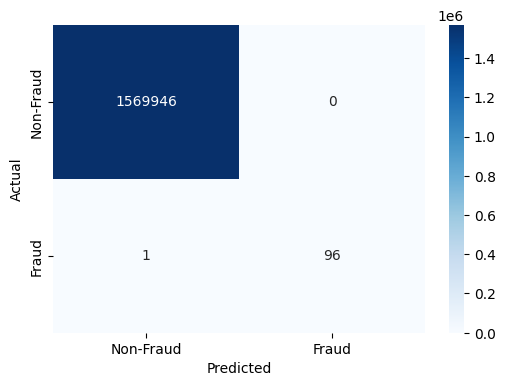

array([[1569946,       0],
       [      1,      96]])

In [20]:
print("F1:", metrics.calc_f1(y, y_pred))
print("ROC AUC:", metrics.calc_auc_roc(y, y_pred))
print("ROC PR:", metrics.calc_auc_pr(y, y_pred))
metrics.generate_confusion_matrix(y, y_pred, model + '_confusion_matrix.png')

In [21]:
if model_to_use in ['lr', 'dt']:
    y_pred_proba = clf.predict_proba(X_standardized)
elif model_to_use == 'xgb':
    y_pred_proba = y_pred_proba.reshape((-1, 1))
    y_pred_proba = np.hstack([np.zeros((y_pred_proba.shape[0], 1)), y_pred_proba])
    
utils.generate_prediction_report(path_to_data_inf_org, path_to_data_inf_transformed, y, y_pred, y_pred_proba, 'prediction_report.csv')

,id,sender_id,receiver_id,amount,status,flowname,bankfees,timestamp,sender_age,receiver_age,fraud,fraud_predicted,fraud_predicted_proba,fraud_rank
1574264,60187f84f25afb235f20f021159ebf46,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:18:58.437064+00:00,76,40,1,1,9.999998e-01,1
1574265,b899e57fb5303729141c521edc14910d,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:26:33.458626+00:00,76,40,1,1,9.999998e-01,2
1574266,b9ea123c60d3f11611bcfed314f0cdfa,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 17:47:39.053778+00:00,76,40,1,1,9.999998e-01,3
1574267,6dacd6040b4926ad3d47c950484bf0ec,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:14:09.962350+00:00,76,40,1,1,9.999998e-01,4
1574268,2a8caab9808ded90226f000b157c9c3c,a8d88604449da4bbe0b318923b6d860e,68a1ba743df5ea66c42e2e4337d7127a,900.0,PaymentSucceededV0,e395101288f53121cee2480bc7f24c4b,0.0,2024-05-22 18:29:40.218278+00:00,76,40,1,1,9.999998e-01,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549013,4135bffa23b1e9a973cf33470d2f262d,77a2e30855edf0394006fd053d005e20,77a2e30855edf0394006fd053d005e20,881.0,PaymentSucceededV0,36628d303cdd443b0d1d475b58a76878,0.0,2024-05-13 16:48:27.326398+00:00,38,38,0,0,4.980734e-08,1574357
551945,4c88714e99a8f45e40f582fa18db8887,d4ffad0ac205d5c1cf7091a3631b1130,9cd0607bdcd873c21dfc556e61f0d1a8,756.0,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-13 16:45:56.940428+00:00,28,56,0,0,4.980734e-08,1574358
574018,19af5bb41d810ab84e7240dfa451ecb3,cef3e8531c86c28e294b64d225c63451,d76187c765047640c41bb2d6ce068648,702.5,PaymentSucceededV0,6fed08d35288c5c3571085571e34c7c1,0.0,2024-05-13 20:14:05.620902+00:00,30,28,0,0,4.980734e-08,1574359
635423,ffe7a6f86ed7b3040fc235f59e24ef7c,52bd0c6fc11e1e4c41f75c0472e86645,565ed771a78433db30da0f4ef94216ed,800.0,PaymentSucceededV0,9022a190bcbcd8f1fc2f9f6df8bf1f92,0.0,2024-05-13 13:29:29.878628+00:00,38,46,0,0,4.980734e-08,1574360
